In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from IPython.display import Image
import pandas as pd
from functools import reduce
!pip install xgboost
from xgboost import XGBClassifier 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load and display the dataset
df = pd.read_csv('Airline_Delay_Cause.csv')
df.head()

,year,month,carrier,carrier_name,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,89.0,13.0,2.25,1.60,3.16,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,62.0,10.0,1.97,0.04,0.57,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,62.0,10.0,2.73,1.18,1.80,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,66.0,12.0,3.69,2.27,4.47,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,92.0,22.0,7.76,0.00,2.96,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [4]:


# Drop rows with missing key columns needed for target/label creation
df = df.dropna(subset=["arr_delay", "arr_flights", "arr_del15"]).reset_index(drop=True)

# Remove rows where arr_flights is zero to avoid division by zero
df = df[df["arr_flights"] > 0].reset_index(drop=True)

# Create delay_rate feature (fraction of flights delayed >=15 minutes)
df["delay_rate"] = df["arr_del15"] / df["arr_flights"]

print("Dataset shape after cleaning:", df.shape)
print(df.head())

# One-hot encode categorical and object features
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("\nCategorical columns:", list(cat_cols))

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head()

# Create target variables 
X_reg = df_encoded.drop("arr_delay", axis=1)
y_reg = df_encoded["arr_delay"]

# Classification target: high vs low delay_rate
delay_rate_threshold = 0.25   # 25% of flights delayed >= 15 minutes
df_encoded["High_Delay"] = (df["delay_rate"] > delay_rate_threshold).astype(int)

X_cls = df_encoded.drop("High_Delay", axis=1)
y_cls = df_encoded["High_Delay"]

Dataset shape after cleaning: (171223, 21)
   year  month carrier       carrier_name airport  arr_flights  arr_del15  \
0  2023      8      9E  Endeavor Air Inc.     ABE         89.0       13.0   
1  2023      8      9E  Endeavor Air Inc.     ABY         62.0       10.0   
2  2023      8      9E  Endeavor Air Inc.     AEX         62.0       10.0   
3  2023      8      9E  Endeavor Air Inc.     AGS         66.0       12.0   
4  2023      8      9E  Endeavor Air Inc.     ALB         92.0       22.0   

   carrier_ct  weather_ct  nas_ct  ...  late_aircraft_ct  arr_cancelled  \
0        2.25        1.60    3.16  ...              5.99            2.0   
1        1.97        0.04    0.57  ...              7.42            0.0   
2        2.73        1.18    1.80  ...              4.28            1.0   
3        3.69        2.27    4.47  ...              1.57            1.0   
4        7.76        0.00    2.96  ...             11.28            2.0   

   arr_diverted  arr_delay  carrier_delay  

In [5]:
# Correct train/test split: don't overwrite the train variable
from sklearn.model_selection import train_test_split

x_train_cls, x_test_cls,y_train_cls, y_test_cls  = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)  # Train/test split

In [ ]:
XGEEBUS = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [ ]:
XGEEBUS.fit(x_train_cls, y_train_cls)
y_pred_cls = XGEEBUS.predict(x_test_cls)
y_pred_proba_cls_XGEEBUS = XGEEBUS.predict_proba(x_test_cls)[:, 1]

print('XGBoost Classifier Performance:')
print('Accuracy:', accuracy_score(y_test_cls, y_pred_cls))
print('ROC AUC Score:', roc_auc_score(y_test_cls, y_pred_proba_cls_XGEEBUS))
print('classification_report:\n', classification_report(y_test_cls, y_pred_cls))

XGBoost Classifier Performance:
Accuracy: 0.9995327739599353
ROC AUC Score: 0.9999992247262279
classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39887
           1       1.00      1.00      1.00     11480

    accuracy                           1.00     51367
   macro avg       1.00      1.00      1.00     51367
weighted avg       1.00      1.00      1.00     51367



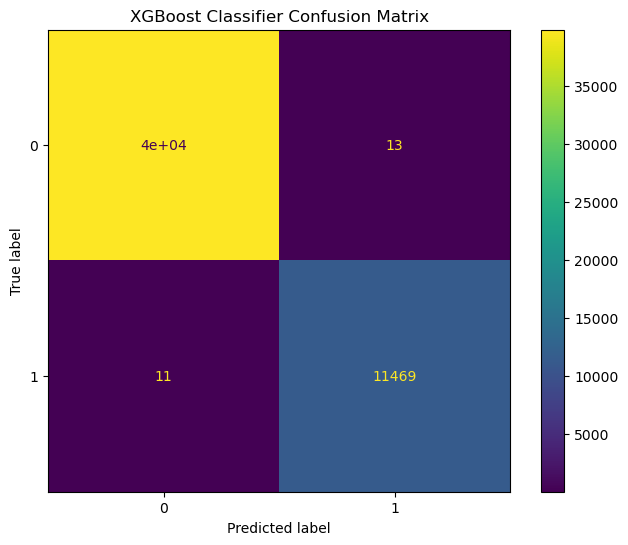

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test_cls, y_pred_cls, ax=ax)
plt.title('XGBoost Classifier Confusion Matrix')
plt.show()

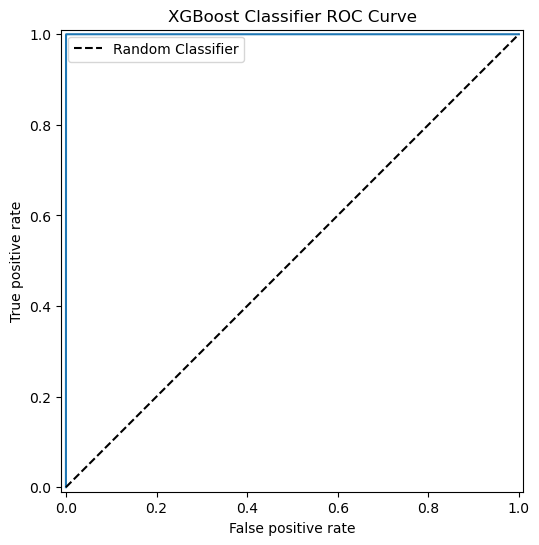

In [30]:
from sklearn.metrics import RocCurveDisplay, roc_curve 
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_cls, y_pred_proba_cls_XGEEBUS)

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_title('XGBoost Classifier ROC Curve')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()
plt.show()
